In [31]:
import os
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [32]:
data_dir = './archive'

In [33]:
# Configuración del dataset
class CustomDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("L")  # Convertimos a escala de grises
        if self.transform:
            image = self.transform(image)
        return image, label

In [34]:
# Función para cargar las imágenes y etiquetas
def load_data(data_dir):
    file_paths = []
    labels = []
    class_mapping = {
        "decks/cracked": 0,
        "decks/non-cracked": 1,
        "pavements/cracked": 2,
        "pavements/non-cracked": 3,
        "walls/cracked": 4,
        "walls/non-cracked": 5,
    }

    for label, idx in class_mapping.items():
        folder = os.path.join(data_dir, label)
        if os.path.exists(folder):  # Verificar que la carpeta exista
            for file in os.listdir(folder):
                file_path = os.path.join(folder, file)
                if os.path.isfile(file_path):  # Verificar que es un archivo válido
                    file_paths.append(file_path)
                    labels.append(idx)

    return file_paths, labels
file_paths, labels = load_data(data_dir)


In [35]:
# Entrenamiento y prueba
train_paths, test_paths, train_labels, test_labels = train_test_split(
    file_paths, labels, test_size=0.2, random_state=26, stratify=labels
)
# Entrenamiento y validación
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.2, random_state=26, stratify=train_labels
)

# Transformaciones y DataLoaders
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(5),
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,)),
])

train_dataset = CustomDataset(train_paths, train_labels, transform=transform)
val_dataset = CustomDataset(val_paths, val_labels, transform=transform)
test_dataset = CustomDataset(test_paths, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [36]:
# Definición del modelo
class ConvNet(nn.Module):
    def __init__(self, dropout=0.2):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(32 * 16 * 16, 128)
        self.dropout = nn.Dropout(dropout)  #dropout dinamico
        self.fc2 = nn.Linear(128, 6)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Configuración de hiperparámetros
params = {
    'dropout': 0.2,
    'lr': 0.001,
    'weight_decay': 0.0001,
    'batch_size': 64,
    'epochs': 10,
    'patience': 3,
}

def initialize_model(params):
    model = ConvNet(dropout=params['dropout'])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(
        model.parameters(),
        lr=params['lr'],
        weight_decay=params['weight_decay']
    )
    return model, criterion, optimizer

model, criterion, optimizer = initialize_model(params)

def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for images, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)

def validate_one_epoch(model, dataloader, criterion):
    model.eval()
    val_loss = 0.0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.numpy())
    val_loss /= len(dataloader)
    report = classification_report(y_true, y_pred, output_dict=True)
    val_accuracy = report['accuracy']
    val_f1 = report['weighted avg']['f1-score']
    return val_loss, val_accuracy, val_f1

# Configuración de early stopping
patience = params['patience']
best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(params['epochs']):
    # Entrenamiento
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    # Validación
    val_loss, val_accuracy, val_f1 = validate_one_epoch(model, val_loader, criterion)
    # Imprimir métricas
    print(f"Epoch {epoch + 1}/{params['epochs']} - "
          f"Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, "
          f"Val Accuracy: {val_accuracy:.4f}, "
          f"Val F1-Score: {val_f1:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"No hay mejora en la pérdida de validación por {epochs_no_improve} época(s).")

    if epochs_no_improve >= patience:
        print("Early stopping activado. Entrenamiento detenido.")
        break

Epoch 1/10 - Train Loss: 1.3403, Val Loss: 1.2071, Val Accuracy: 0.4094, Val F1-Score: 0.3041
Epoch 2/10 - Train Loss: 1.2136, Val Loss: 1.1594, Val Accuracy: 0.4293, Val F1-Score: 0.4075
Epoch 3/10 - Train Loss: 1.1701, Val Loss: 1.1240, Val Accuracy: 0.4576, Val F1-Score: 0.4326
Epoch 4/10 - Train Loss: 1.1370, Val Loss: 1.1048, Val Accuracy: 0.4521, Val F1-Score: 0.3917
Epoch 5/10 - Train Loss: 1.0998, Val Loss: 1.0588, Val Accuracy: 0.5037, Val F1-Score: 0.4816
Epoch 6/10 - Train Loss: 1.0781, Val Loss: 1.0478, Val Accuracy: 0.5022, Val F1-Score: 0.4635
Epoch 7/10 - Train Loss: 1.0316, Val Loss: 1.0265, Val Accuracy: 0.5052, Val F1-Score: 0.4943
Epoch 8/10 - Train Loss: 1.0328, Val Loss: 1.0437, Val Accuracy: 0.5077, Val F1-Score: 0.5040
No hay mejora en la pérdida de validación por 1 época(s).
Epoch 9/10 - Train Loss: 0.9971, Val Loss: 0.9706, Val Accuracy: 0.5427, Val F1-Score: 0.5020
Epoch 10/10 - Train Loss: 0.9804, Val Loss: 1.0579, Val Accuracy: 0.5059, Val F1-Score: 0.4859
N

Test Loss: 1.0638
Classification Report:
                        precision    recall  f1-score   support

        decks/cracked       0.55      0.25      0.34       381
    decks/non-cracked       0.71      0.18      0.29       412
    pavements/cracked       0.79      0.43      0.56       522
pavements/non-cracked       0.63      0.89      0.74       524
        walls/cracked       0.41      0.57      0.48       770
    walls/non-cracked       0.47      0.61      0.53       783

             accuracy                           0.52      3392
            macro avg       0.59      0.49      0.49      3392
         weighted avg       0.57      0.52      0.50      3392



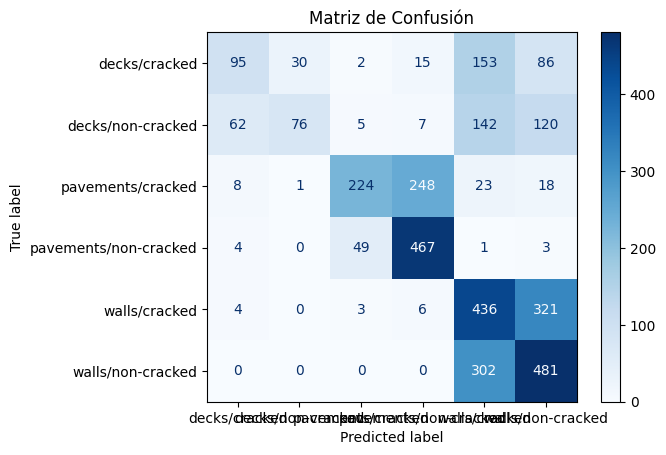

In [37]:
# Evaluación en el conjunto de prueba
test_loss = 0.0
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())

test_loss /= len(test_loader)
report = classification_report(y_true, y_pred, target_names=[
    "decks/cracked", "decks/non-cracked", "pavements/cracked",
    "pavements/non-cracked", "walls/cracked", "walls/non-cracked"
])

print(f"Test Loss: {test_loss:.4f}")
print("Classification Report:\n", report)

# %%
# Matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[
    "decks/cracked", "decks/non-cracked", "pavements/cracked",
    "pavements/non-cracked", "walls/cracked", "walls/non-cracked"
])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()